# Run ensemble model and submit predictions

### Imports

In [1]:
import os
if 'notebooks' in os.getcwd(): os.chdir('../..')  # change to main directory
print('Working directory:', os.getcwd() )

Working directory: /scratch/snx3000/bp000429/submission/adrian_sensorium


In [2]:
import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from nnfabrik.builder import get_data, get_model, get_trainer

from sensorium.utility import submission
from sensorium.utility.training import read_config

### Load configuration for model

In [3]:
# Loading config only for ensemble 0, because all 5 models have the same config (except
# for the seed and dataloader train/validation split)

config_file = 'notebooks/submission_m4/config_m4_ens0.yaml'
config = read_config( config_file )
print(config)

ordereddict([('data_sets', ['all']), ('dataset_fn', 'sensorium.datasets.static_loaders'), ('dataset_config', ordereddict([('normalize', True), ('include_behavior', True), ('include_eye_position', True), ('batch_size', 128), ('scale', 0.25), ('preload_from_merged_data', True), ('include_trial_id', True), ('include_rank_id', True), ('include_history', True), ('include_behav_state', True), ('adjusted_normalization', True), ('use_ensemble_tier', True), ('ensemble_nr', 0)])), ('model_fn', 'sensorium.models.modulated_stacked_core_full_gauss_readout'), ('model_seed', 100), ('model_config', ordereddict([('pad_input', False), ('stack', -1), ('layers', 4), ('input_kern', 9), ('gamma_input', 9.8), ('gamma_readout', 0.48), ('hidden_kern', 10), ('hidden_channels', 64), ('depth_separable', True), ('grid_mean_predictor', ordereddict([('type', 'cortex'), ('input_dimensions', 2), ('hidden_layers', 4), ('hidden_features', 20), ('nonlinearity', 'ReLU'), ('final_tanh', True)])), ('init_sigma', 0.14), ('in

### Prepare dataloader

In [4]:
# Use only one dataloader, since test and final_test are the same for all ensembles
basepath = "notebooks/data/"
filenames = [os.path.join(basepath, file) for file in os.listdir(basepath) if ".zip" in file ]
filenames = [file for file in filenames if 'static26872-17-20' not in file]

dataset_fn = config['dataset_fn']  # 'sensorium.datasets.static_loaders'
dataset_config = {'paths': filenames,
                  **config['dataset_config'],
                 }

dataloaders = get_data(dataset_fn, dataset_config)

Loading ensemble tiers for nr 0
Loading ensemble tiers for nr 0
Loading ensemble tiers for nr 0
Loading ensemble tiers for nr 0
Loading ensemble tiers for nr 0
Loading ensemble tiers for nr 0


### Load trained models

In [5]:
# Instantiate all five models
model_list = list()

for i in range(5):
    # all models have the same parameters
    model_fn = config['model_fn']     # e.g. 'sensorium.models.modulated_stacked_core_full_gauss_readout'
    model_config = config['model_config']

    model = get_model(model_fn=model_fn,
                      model_config=model_config,
                      dataloaders=dataloaders,
                      seed=config['model_seed'],
                     )

    # Load trained weights from specific ensemble
    save_file = 'saved_models/config_m4_ens{}/saved_model_v1.pth'.format(i)
    model.load_state_dict(torch.load(save_file))
    model_list.append( model )

### Combine them into one ensemble model

In [6]:
from sensorium.models.ensemble import EnsemblePrediction

In [7]:
ensemble = EnsemblePrediction(model_list, mode='mean')

### Generate submission file

In [8]:
dataset_name = '27204-5-13'

submission.generate_submission_file(trained_model=ensemble, 
                                    dataloaders=dataloaders,
                                    data_key=dataset_name,
                                    path="notebooks/submission_m4/results/",
                                    device="cuda")

Submission file saved for tier: live_test. Saved in: notebooks/submission_m4/results/submission_file_live_test.csv
Submission file saved for tier: final_test. Saved in: notebooks/submission_m4/results/submission_file_final_test.csv


### Evaluate model on all datasets

In [9]:
from sensorium.utility import get_correlations, get_signal_correlations, get_fev
from sensorium.utility.measure_helpers import get_df_for_scores

#### Test data

In [10]:
single_trial_correlation = get_correlations(ensemble, dataloaders, tier="test", device="cuda", as_dict=True)

df = get_df_for_scores(session_dict=single_trial_correlation,
                                    measure_attribute="Single Trial Correlation"
                      )

In [11]:
%matplotlib inline

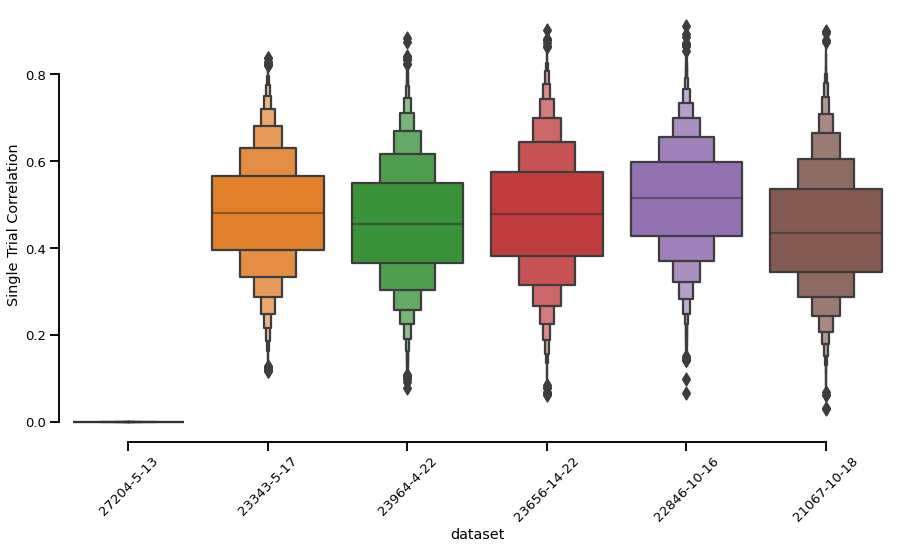

In [12]:
sns.set_context("talk", font_scale=.8)
fig = plt.figure(figsize=(15,8))
sns.boxenplot(x="dataset", y="Single Trial Correlation", data=df, )
plt.xticks(rotation = 45);
sns.despine(trim=True)

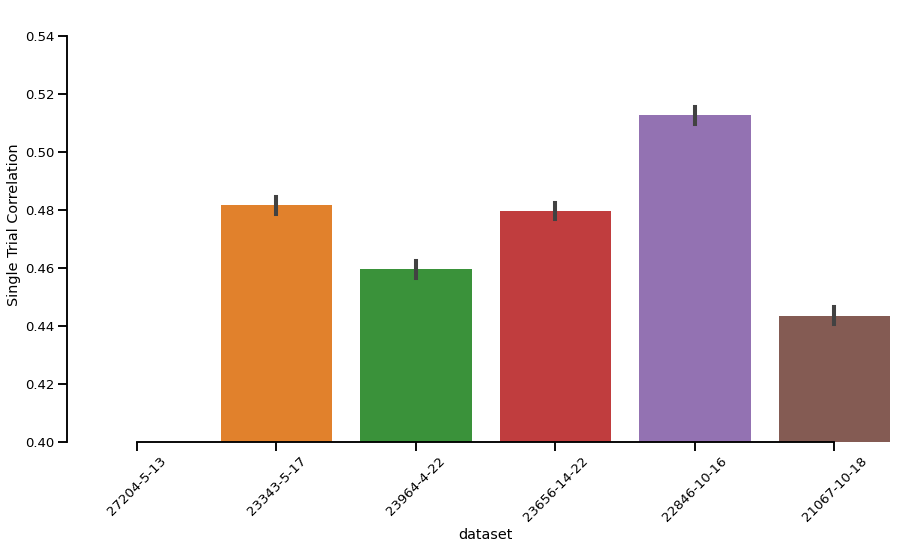

In [13]:
sns.set_context("talk", font_scale=.8)
fig = plt.figure(figsize=(15,8))
sns.barplot(x="dataset", y="Single Trial Correlation", data=df, )
plt.xticks(rotation = 45);
plt.ylim(0.4,0.55)
sns.despine(trim=True)

In [14]:
df.groupby('dataset').describe()

Single Trial Correlation                                          \
                               count      mean       std       min       25%   
dataset                                                                        
21067-10-18                   8372.0  0.443405  0.135999  0.030354  0.345778   
22846-10-16                   7344.0  0.512561  0.122075  0.066971  0.428538   
23343-5-17                    7334.0  0.481541  0.126222  0.116082  0.395040   
23656-14-22                   8107.0  0.479599  0.139901  0.061587  0.382142   
23964-4-22                    8098.0  0.459387  0.132553  0.077549  0.365620   
27204-5-13                    7538.0  0.000000  0.000000  0.000000  0.000000   

                                           
                  50%       75%       max  
dataset                                    
21067-10-18  0.434935  0.537070  0.901094  
22846-10-16  0.515296  0.598105  0.910621  
23343-5-17   0.479932  0.567062  0.838450  
23656-14-22  0.477541  0.576037  0.902068  
23964-4-22   0.456629  0.550805  0.883947  
27204-5-13   0.000000  0.000000  0.000000